1. Exploratory Data Analysis
2. Testing pretrained models Textblob and Vader
3. roBERTa test model
4. Machine learning approach - Random Forest
5. Implementation of Random forest, Naive Bayes and SVM Final model
6. Testing models on real time tweets
7. Testing models on labelled data to get accuracy of TextBlob and VADER
8. Impplementation and testing of BiLSTM model

# Exploratory Data Analysis

In [66]:
#Import libraries

import tweepy
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go

import nltk
from nltk.corpus import twitter_samples
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
sns.set()


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from textblob import TextBlob

In [67]:
#pip install plotly

In [68]:
consumer_key = 'wF3wYz1inOqUeTPd5yExTljQO'
consumer_secret =  'M3qg07wD4ch9xBC0L6xLQ1lHtkzQnC3KJqRszNvBe5RjoiJSky'
access_token = '69267321-OS2762xKCOIEbMERLjOyARUXUheDnCst2TIXJp7Vc'
access_token_secret = 'dN6BLhgTj4nSSwg48Fwx4pdLIzEjrUvi95CVLTWxR2UMQ'

In [69]:
#Authenticate with credentials

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth,wait_on_rate_limit=True)

In [70]:
key_word = 'review'
limit = 9000

In [32]:
#Iteraate through tweets and print 10

i = 0
for tweet in api.search_tweets(key_word):
    print(i, tweet.text, '\n')
    i=i+1

0 RT @Ness_SeaGlass: Thank you for your order and your lovely review.
https://t.co/GDWaOArE1p

#MHHSBD https://t.co/vIvjgcRCIz 

1 RT @mtracey: JFK received a memo from Arthur Schlesinger Jr. in June 1961 warning that the CIA "possesses many of the characteristics of a… 

2 @GRITCULT Application under review. 

Forgiveness will be on a work visa until all details have been gathered 

3 RT @mtracey: JFK received a memo from Arthur Schlesinger Jr. in June 1961 warning that the CIA "possesses many of the characteristics of a… 

4 RT @Indie_Blast: If you're looking for a festive feeling puzzle game this Xmas, try out Puzzledorf. It has its own Xmas levels. 😍
Check out… 

5 RT @Indie_Blast: If you're looking for a festive feeling puzzle game this Xmas, try out Puzzledorf. It has its own Xmas levels. 😍
Check out… 

6 RT @mtracey: JFK received a memo from Arthur Schlesinger Jr. in June 1961 warning that the CIA "possesses many of the characteristics of a… 

7 BREAKING EXCLUSIVE: The 2021 Mari

In [47]:
#Cleaning tweets

def TextClean(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'@[a-z0-9_]\S+', '', tweet)
    tweet = re.sub(r'#[a-z0-9_]\S+', '', tweet)
    tweet = re.sub(r'&[a-z0-9_]\S+', '', tweet)
    tweet = re.sub(r'[?!.+,;:$%&"]+', '', tweet)
    tweet = re.sub(r'rt[\s]+', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    tweet = re.sub(r'\$+', '', tweet)
    tweet = re.sub(r'rt+' , '', tweet)
    tweet = re.sub(r'https?:?\/\/\S+', '', tweet)
    
    return tweet

In [48]:
#Search for keyword and pull the matching tweets

def tweet_search(key_word):
    i = 0
    tweets_df = pd.DataFrame(columns = ['Datetime', 'Tweet', 'Username', 'Retweets', 'Followers'])
    for tweet in tweepy.Cursor(api.search_tweets, q = key_word, count = 100, lang = 'en', tweet_mode = 'extended').items():
        print('Tweets downloaded:', i, '/', limit, end = '\r')
        if tweet.user.followers_count > 500:
            tweets_df = tweets_df.append({'Datetime': tweet.created_at,
                                          'Tweet': tweet.full_text, 
                                          'Username': tweet.user.screen_name, 
                                          'Retweets': tweet.retweet_count,
                                          'Followers': tweet.user.followers_count,}, ignore_index = True)
            i += 1
        if i>= limit:
            break
        else:
            pass
    tweets_df['Datetime'] = pd.to_datetime(tweets_df['Datetime'], format = '%Y.%m.%d %H:%M:%S')
    tweets_df.set_index('Datetime' ,inplace = True)
    tweets_df.drop_duplicates(subset = ['Tweet'], inplace = True)
    tweets_df['CleanTweet'] = tweets_df['Tweet'].apply(TextClean)
    tweet_tokenizer = TweetTokenizer()
    tweets_df['CleanTweet'] = tweets_df['CleanTweet'].apply(tweet_tokenizer.tokenize)
    tweets_df['CleanTweet'] = [', '.join(map(str, token)) for token in tweets_df['CleanTweet']]
    
    #tweets_df.to_csv(key_word + '.csv', encoding = 'utf-8')
    return tweets_df

In [49]:
tweets_df=tweet_search(key_word)
tweets_df

,Tweet,Username,Retweets,Followers,CleanTweet
Datetime,,,,,
2023-01-07 01:42:35+00:00,RT @KevinGeorgeEng: Review 32 ...Some Friday m...,Howie7951,29,2771,"review, some, friday, morning, advanced, engli..."
2023-01-07 01:42:33+00:00,"“Transit matters, and so does architecture.” M...",alexbozikovic,0,23339,"“, transit, matters, and, so, does, architectu..."
2023-01-07 01:42:32+00:00,RT @JoanneMartino9: @jomilleweb &amp; this is ...,GrannieSus,7,1046,"this, is, the, reason, why, i, don, ’, t, beli..."
2023-01-07 01:42:26+00:00,A handful of public school districts are manda...,axios,0,645755,"a, handful, of, public, school, districts, are..."
2023-01-07 01:42:26+00:00,RT @JimboFett87: The Legion #5 Review! https:/...,BringBackLSH,2,1767,"the, legion, #, review"
...,...,...,...,...,...
2023-01-06 20:48:51+00:00,READING THEMED MERCH\nDesigns available on 20+...,INDIEBOOKSOURCE,0,10530,"reading, themed, merch, designs, available, on..."
2023-01-06 20:48:50+00:00,RT @JohnWolfeYT: Things I'm working on right n...,_TheRockyGamer_,5,1747,"things, i'm, working, on, right, now, -, best,..."
2023-01-06 20:48:49+00:00,"RT @weknowottawa: ☀️""Melanie is a ray of sunsh...",HamreREMAX,1,2791,"☀, ️melanie, is, a, ray, of, sunshine, and, wa..."


In [33]:
all_tweets = ' '.join(tweet for tweet in tweets_df['CleanTweet'])
all_tweets

"got, my, first, review, i, am, so, excited, to, share, it, marquez, ’, s, story, is, one, we, all, need, to, know, as, it, is, no, … 🚨, as, per, year, review, repos, since, november, 🇪🇹, |, n, govt, forces, and, allied, 🇪🇷, |, n, soldiers, have, commit, … as, per, year, review, repos, since, november, 🇪🇹, |, n, govt, forces, and, allied, 🇪🇷, |, n, soldiers, have, commi, … journal, editors, how, long, do, you, give, potential, reviewers, to, accept, or, decline, your, invitation, to, review check, out, the, latest, ', the, weekly, pov, ', the, way, of, water, review, jeremy, renner, injured, and, more i, ’, m, st, i, believe, spr-level, round, every, day, minimum, with, spr, level, review, of, results, /, progress, in, evening, as, well, consultant, check-in, (, doesn, ’, t, have, to, be, a, full, wr, ), regularly, with, frequency, dependent, on, specialty, /, patient, mix, and, competence, of, spr, probably, -, /, week just, submitted, this, to, mit, for, final, review, grading as, pe

In [34]:
WordCloud = WordCloud(width = 800, height = 400, random_state = 21, max_font_size = 100, collocations = False).generate(all_tweets)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

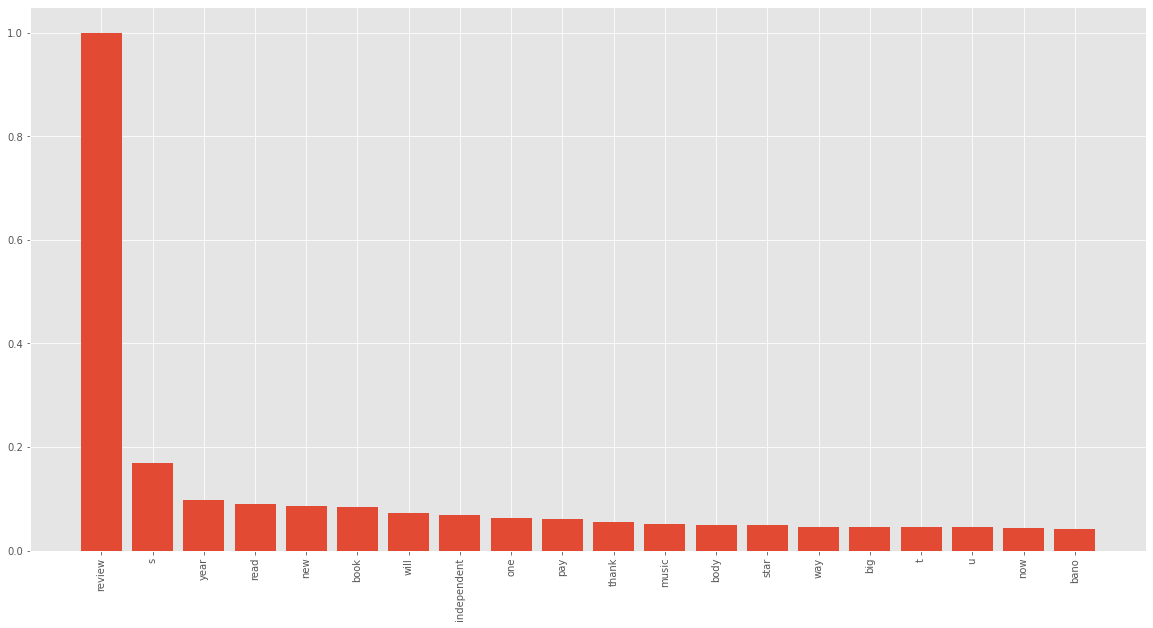

In [33]:
plt.style.use('ggplot')
word_frequency = pd.DataFrame.from_dict(data = WordCloud.words_,orient = 'index')
word_frequency = word_frequency.head(20)
plt.figure(figsize = (20, 10))
plt.bar(word_frequency.index, word_frequency[0])
plt.xticks(rotation = 90)

(-0.5, 799.5, 399.5, -0.5)

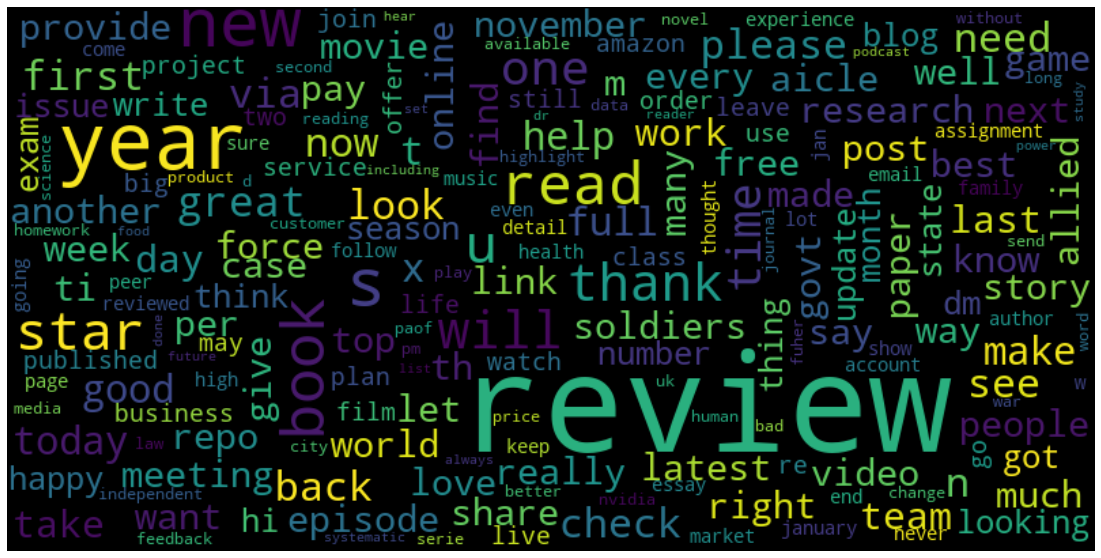

In [35]:
plt.figure(figsize = (20,10))
plt.imshow(WordCloud, interpolation = 'bilinear')
plt.axis('off')

# Testing pretrained models Textblob and Vader

In [36]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tijov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
#Tokenization

tokens = word_tokenize(all_tweets)
tokens

['got',
 ',',
 'my',
 ',',
 'first',
 ',',
 'review',
 ',',
 'i',
 ',',
 'am',
 ',',
 'so',
 ',',
 'excited',
 ',',
 'to',
 ',',
 'share',
 ',',
 'it',
 ',',
 'marquez',
 ',',
 '’',
 ',',
 's',
 ',',
 'story',
 ',',
 'is',
 ',',
 'one',
 ',',
 'we',
 ',',
 'all',
 ',',
 'need',
 ',',
 'to',
 ',',
 'know',
 ',',
 'as',
 ',',
 'it',
 ',',
 'is',
 ',',
 'no',
 ',',
 '…',
 '🚨',
 ',',
 'as',
 ',',
 'per',
 ',',
 'year',
 ',',
 'review',
 ',',
 'repos',
 ',',
 'since',
 ',',
 'november',
 ',',
 '🇪🇹',
 ',',
 '|',
 ',',
 'n',
 ',',
 'govt',
 ',',
 'forces',
 ',',
 'and',
 ',',
 'allied',
 ',',
 '🇪🇷',
 ',',
 '|',
 ',',
 'n',
 ',',
 'soldiers',
 ',',
 'have',
 ',',
 'commit',
 ',',
 '…',
 'as',
 ',',
 'per',
 ',',
 'year',
 ',',
 'review',
 ',',
 'repos',
 ',',
 'since',
 ',',
 'november',
 ',',
 '🇪🇹',
 ',',
 '|',
 ',',
 'n',
 ',',
 'govt',
 ',',
 'forces',
 ',',
 'and',
 ',',
 'allied',
 ',',
 '🇪🇷',
 ',',
 '|',
 ',',
 'n',
 ',',
 'soldiers',
 ',',
 'have',
 ',',
 'commi',
 ',',
 '…',
 'journal'

In [38]:
print('Number of word in tweets: ', len(all_tweets))
print('Number of tokens:', len(tokens))

Number of word in tweets:  815525
Number of tokens: 252003


In [39]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tijov\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [40]:
#Lematization

lemmatizer = WordNetLemmatizer()
lemma = [lemmatizer.lemmatize(tweet, pos = 'v') for tweet in tokens]
print(tokens[:20])
print(lemma[:20])

['got', ',', 'my', ',', 'first', ',', 'review', ',', 'i', ',', 'am', ',', 'so', ',', 'excited', ',', 'to', ',', 'share', ',']
['get', ',', 'my', ',', 'first', ',', 'review', ',', 'i', ',', 'be', ',', 'so', ',', 'excite', ',', 'to', ',', 'share', ',']


In [41]:
#Stemming
porter_stemmer = PorterStemmer()
stemm = [porter_stemmer.stem(tweet) for tweet in tokens]

In [42]:
print(tokens[:20])
print(stemm[:20])

['got', ',', 'my', ',', 'first', ',', 'review', ',', 'i', ',', 'am', ',', 'so', ',', 'excited', ',', 'to', ',', 'share', ',']
['got', ',', 'my', ',', 'first', ',', 'review', ',', 'i', ',', 'am', ',', 'so', ',', 'excit', ',', 'to', ',', 'share', ',']


In [43]:
print('Number of word in tweets: ', len(all_tweets))
print('Number of tokens:', len(tokens))
print('Number of lemmas:', len(lemma))
print('Number of stemms:', len(stemm))

Number of word in tweets:  815525
Number of tokens: 252003
Number of lemmas: 252003
Number of stemms: 252003


In [55]:
df = pd.DataFrame(columns = ['Tokens', 'Stemm', 'Lemma'])
df['Tokens'] = tokens[:50]
df['Stemm'] = stemm[:50]
df['Lemma'] = lemma[:50]
df

,Tokens,Stemm,Lemma
0,britain,britain,britain
1,is,is,be
2,world,world,world
3,’,’,’
4,s,s,s
5,largest,largest,largest
6,regulated,regul,regulate
7,online,onlin,online
8,gambling,gambl,gamble
9,market,market,market


In [46]:
from textblob import TextBlob
print(TextBlob('This is good').sentiment)
print(TextBlob('This is really good').sentiment)
print(TextBlob('This is great').sentiment)
print(TextBlob('This is terrible').sentiment)
print(TextBlob('How are you? ').sentiment)
print(TextBlob('How are you? :)').sentiment)
print(TextBlob('This is fine').sentiment)
print(TextBlob('This is fine!').sentiment)
print(TextBlob('This is FINE').sentiment)
print(TextBlob('I used to like him, but now I see he is a jerk').sentiment)
print(TextBlob('I used to love him, but now I see he is a jerk').sentiment)

Sentiment(polarity=0.7, subjectivity=0.6000000000000001)
Sentiment(polarity=0.7, subjectivity=0.6000000000000001)
Sentiment(polarity=0.8, subjectivity=0.75)
Sentiment(polarity=-1.0, subjectivity=1.0)
Sentiment(polarity=0.0, subjectivity=0.0)
Sentiment(polarity=0.5, subjectivity=1.0)
Sentiment(polarity=0.4166666666666667, subjectivity=0.5)
Sentiment(polarity=0.5208333333333334, subjectivity=0.5)
Sentiment(polarity=0.4166666666666667, subjectivity=0.5)
Sentiment(polarity=0.0, subjectivity=0.0)
Sentiment(polarity=0.5, subjectivity=0.6)


In [55]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

In [45]:
print(vader.polarity_scores('This is good'))
print(vader.polarity_scores('This is really good'))
print(vader.polarity_scores('This is great'))
print(vader.polarity_scores('This is terrible'))
print(vader.polarity_scores('How are you? :)'))
print(vader.polarity_scores('How are you? :('))
print(vader.polarity_scores('This is fine'))
print(vader.polarity_scores('This is fine!'))
print(vader.polarity_scores('This is FINE'))
print(vader.polarity_scores('I used to like him, but now I see he is a jerk'))

{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}
{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'compound': 0.4927}
{'neg': 0.0, 'neu': 0.328, 'pos': 0.672, 'compound': 0.6249}
{'neg': 0.608, 'neu': 0.392, 'pos': 0.0, 'compound': -0.4767}
{'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound': 0.4588}
{'neg': 0.492, 'neu': 0.508, 'pos': 0.0, 'compound': -0.4404}
{'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'compound': 0.2023}
{'neg': 0.0, 'neu': 0.489, 'pos': 0.511, 'compound': 0.2714}
{'neg': 0.0, 'neu': 0.441, 'pos': 0.559, 'compound': 0.368}
{'neg': 0.196, 'neu': 0.694, 'pos': 0.11, 'compound': -0.3291}


In [11]:
#pip install torch torchvision torchaudio

In [133]:
#pip install torch

In [59]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import numpy as np


def vader_compound_score(tweet):
    vader = SentimentIntensityAnalyzer()
    if vader.polarity_scores(tweet)['compound'] >= 0.05:
        return 'Positive'
    elif vader.polarity_scores(tweet)['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
    
def textblob_sentiment(tweet):
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

    
def rf_sentiment(tweet):
    classifier = pickle.load(open('rf_classifier', 'rb'))
    vectorizer = pickle.load(open('rf_vectorizer', 'rb'))
    
    return classifier.predict(vectorizer.transform(list(tweet)))

In [60]:
tweets_df['Vader_sentiment'] = tweets_df['CleanTweet'].apply(vader_compound_score)
tweets_df['TextBlob_sentiment'] = tweets_df['CleanTweet'].apply(textblob_sentiment)
tweets_df['Different_sentiment'] = np.where(tweets_df['Vader_sentiment']!=tweets_df['TextBlob_sentiment'], 1, 0)
tweets_df

,Tweet,Username,Retweets,Followers,CleanTweet,senLen,Vader_sentiment,TextBlob_sentiment,Different_sentiment
Datetime,,,,,,,,,
2023-01-07 01:42:35+00:00,RT @KevinGeorgeEng: Review 32 ...Some Friday m...,Howie7951,29,2771,"review, some, friday, morning, advanced, engli...",140,Positive,Positive,0
2023-01-07 01:42:33+00:00,"“Transit matters, and so does architecture.” M...",alexbozikovic,0,23339,"“, transit, matters, and, so, does, architectu...",120,Neutral,Positive,1
2023-01-07 01:42:32+00:00,RT @JoanneMartino9: @jomilleweb &amp; this is ...,GrannieSus,7,1046,"this, is, the, reason, why, i, don, ’, t, beli...",143,Neutral,Neutral,0
2023-01-07 01:42:26+00:00,A handful of public school districts are manda...,axios,0,645755,"a, handful, of, public, school, districts, are...",216,Positive,Positive,0
2023-01-07 01:42:26+00:00,RT @JimboFett87: The Legion #5 Review! https:/...,BringBackLSH,2,1767,"the, legion, #, review",62,Neutral,Neutral,0
...,...,...,...,...,...,...,...,...,...
2023-01-06 20:48:51+00:00,READING THEMED MERCH\nDesigns available on 20+...,INDIEBOOKSOURCE,0,10530,"reading, themed, merch, designs, available, on...",242,Positive,Positive,0
2023-01-06 20:48:50+00:00,RT @JohnWolfeYT: Things I'm working on right n...,_TheRockyGamer_,5,1747,"things, i'm, working, on, right, now, -, best,...",140,Positive,Positive,0
2023-01-06 20:48:49+00:00,"RT @weknowottawa: ☀️""Melanie is a ray of sunsh...",HamreREMAX,1,2791,"☀, ️melanie, is, a, ray, of, sunshine, and, wa...",138,Positive,Positive,0


In [50]:
#Visualization
vader_pie = [len(tweets_df[tweets_df['Vader_sentiment'] == 'Positive']), 
            len(tweets_df[tweets_df['Vader_sentiment'] == 'Negative']),
            len(tweets_df[tweets_df['Vader_sentiment'] == 'Neutral'])]

blob_pie = [len(tweets_df[tweets_df['TextBlob_sentiment'] == 'Positive']), 
            len(tweets_df[tweets_df['TextBlob_sentiment'] == 'Negative']),
            len(tweets_df[tweets_df['TextBlob_sentiment'] == 'Neutral'])]

labels = ['Positive', 'Negative', 'Neutral']
colors = ['aquamarine','tomato', 'skyblue']

2253 times two approaches show different results


Text(0.5, 1.0, 'TextBlob')

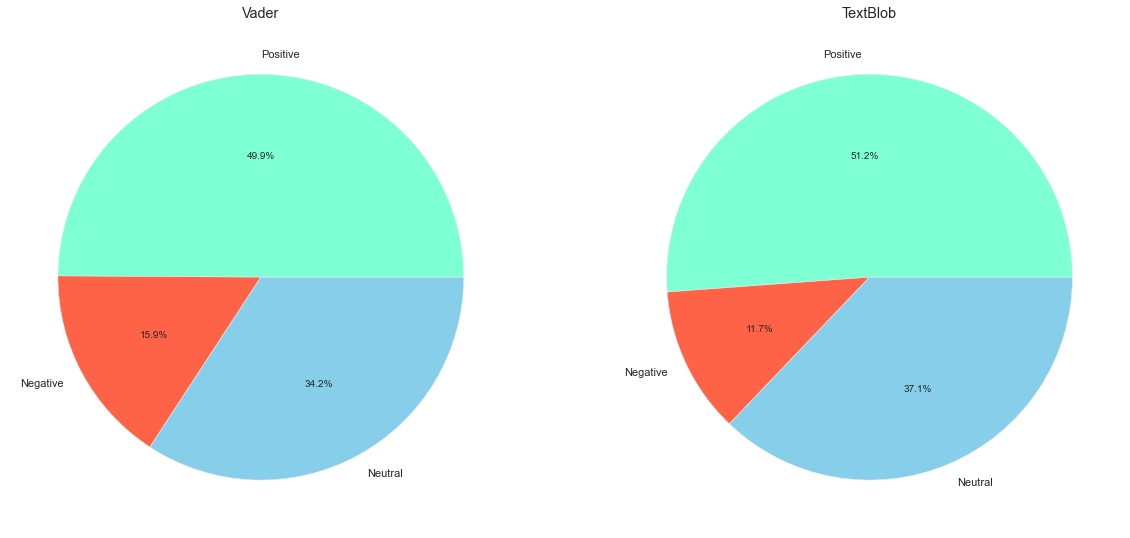

In [51]:
print(len(tweets_df[tweets_df['Different_sentiment'] == 1]), 'times two approaches show different results')

plt.style.use('ggplot')
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.pie(vader_pie, labels = labels, colors = colors, autopct = '%1.1f%%')
plt.title('Vader')

plt.subplot(1,2,2)
plt.pie(blob_pie, labels = labels, colors = colors, autopct = '%1.1f%%')
plt.title('TextBlob')

In [64]:
#pip install transformers

In [65]:
#pip install scipy

# roBERTa test model

In [294]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import numpy as np
import torch

tweet = '@tijo Heartbroken after the last race! Lewis should have won😞'

# precprcess tweet
tweet_temp = []

for word in tweet.split(' '):
    if word.startswith('@') and len(word) > 1:
        word = '@user'
    
    elif word.startswith('http'):
        word = "http"
    tweet_temp.append(word)

tweet_stor = " ".join(tweet_temp)

# load model and tokenizer
roberta = "cardiffnlp/twitter-roberta-base-sentiment"

model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)

labels = ['Negative', 'Neutral', 'Positive']

# sentiment analysis
encoded_tweet = tokenizer(tweet_stor, return_tensors='pt')
# output = model(encoded_tweet['input_ids'], encoded_tweet['attention_mask'])
output = model(**encoded_tweet)

scores = output[0][0].detach().numpy()
scores = softmax(scores)

j = np.argmax(scores)
print(labels[j])


Negative


# Machine Learning based approach trial [Random Forest]

In [86]:
import nltk

In [87]:
# nltk.download('twitter_samples')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

In [88]:
from nltk.corpus import twitter_samples
positive_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tokens = twitter_samples.tokenized('negative_tweets.json')

In [89]:
positive_tokens[:3]

[['#FollowFriday',
  '@France_Inte',
  '@PKuchly57',
  '@Milipol_Paris',
  'for',
  'being',
  'top',
  'engaged',
  'members',
  'in',
  'my',
  'community',
  'this',
  'week',
  ':)'],
 ['@Lamb2ja',
  'Hey',
  'James',
  '!',
  'How',
  'odd',
  ':/',
  'Please',
  'call',
  'our',
  'Contact',
  'Centre',
  'on',
  '02392441234',
  'and',
  'we',
  'will',
  'be',
  'able',
  'to',
  'assist',
  'you',
  ':)',
  'Many',
  'thanks',
  '!'],
 ['@DespiteOfficial',
  'we',
  'had',
  'a',
  'listen',
  'last',
  'night',
  ':)',
  'As',
  'You',
  'Bleed',
  'is',
  'an',
  'amazing',
  'track',
  '.',
  'When',
  'are',
  'you',
  'in',
  'Scotland',
  '?',
  '!']]

In [90]:
from nltk.tag import pos_tag
position_tag = pos_tag(positive_tokens[2])
position_tag

[('@DespiteOfficial', 'JJ'),
 ('we', 'PRP'),
 ('had', 'VBD'),
 ('a', 'DT'),
 ('listen', 'VBN'),
 ('last', 'JJ'),
 ('night', 'NN'),
 (':)', 'NN'),
 ('As', 'IN'),
 ('You', 'PRP'),
 ('Bleed', 'VBP'),
 ('is', 'VBZ'),
 ('an', 'DT'),
 ('amazing', 'JJ'),
 ('track', 'NN'),
 ('.', '.'),
 ('When', 'WRB'),
 ('are', 'VBP'),
 ('you', 'PRP'),
 ('in', 'IN'),
 ('Scotland', 'NNP'),
 ('?', '.'),
 ('!', '.')]

In [91]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemma = []
for word,tag in position_tag:
    lemma.append(lemmatizer.lemmatize(word, pos = 'v'))
lemma
    

['@DespiteOfficial',
 'we',
 'have',
 'a',
 'listen',
 'last',
 'night',
 ':)',
 'As',
 'You',
 'Bleed',
 'be',
 'an',
 'amaze',
 'track',
 '.',
 'When',
 'be',
 'you',
 'in',
 'Scotland',
 '?',
 '!']

In [92]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tijov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [93]:
without_stop = [i for i in lemma if i not in stop_words]
without_stop

['@DespiteOfficial',
 'listen',
 'last',
 'night',
 ':)',
 'As',
 'You',
 'Bleed',
 'amaze',
 'track',
 '.',
 'When',
 'Scotland',
 '?',
 '!']

In [94]:
def clean_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    clean_list = []
    for token, tag in pos_tag(tokens):
        token = token.lower()
        token = re.sub(r'@[a-z0-9_]\S+', '', token)
        token = re.sub(r'#[a-z0-9_]\S+', '', token)
        token = re.sub(r'&[a-z0-9_]\S+', '', token)
        token = re.sub(r'[?!.+,;:$%&"]+', '', token)
        token = re.sub(r'rt[\s]+', '', token)
        token = re.sub(r'\d+', '', token)
        token = re.sub(r'\$+', '', token)
        token = re.sub(r'rt+' , '', token)
        token = re.sub(r'https?:?\/\/\S+', '', token)
        if tag.startswith('NN'):
            position = 'n'
        elif tag.startswith('VB'):
            position = 'v'
        elif tag.startswith('RB'):
            position = 'r'
        elif tag.startswith('JJ'):
            position = 'a'
        else:
            position = 'n'
        clean_list.append(lemmatizer.lemmatize(token, pos = position))
        clean_list = [i for i in clean_list if i not in stop_words and len(i) > 0 and i != ':'] #removing empty space and :
    return clean_list


In [95]:
clean_positive = list(map(clean_tokens, positive_tokens))
clean_negative = list(map(clean_tokens, negative_tokens))

In [96]:
print(positive_tokens[0])
print(clean_positive[0])

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']
['top', 'engage', 'member', 'community', 'week', ')']


(-0.5, 799.5, 399.5, -0.5)

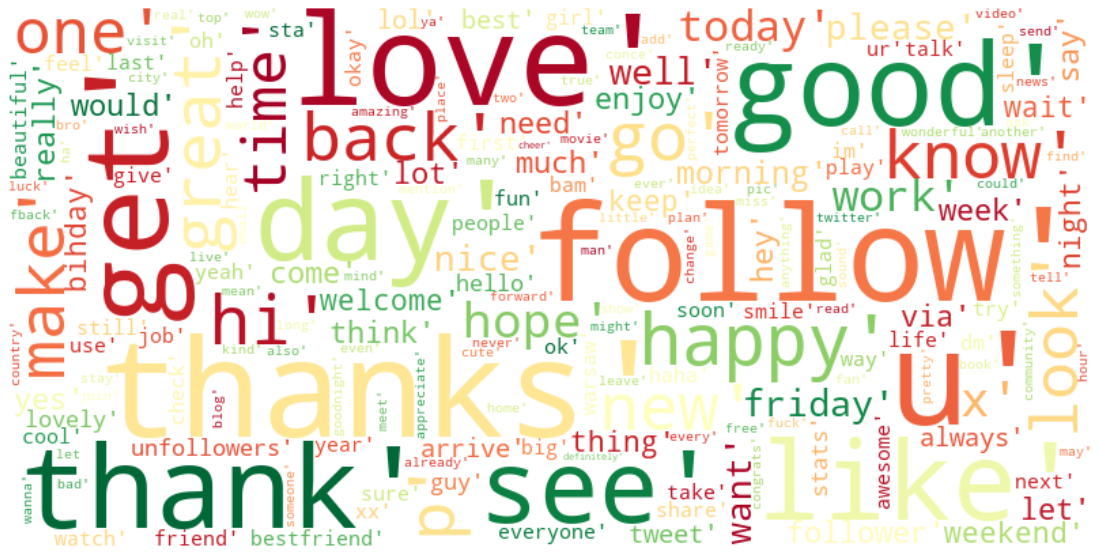

In [20]:
posi_tweets = ''.join(str(v) for v in clean_positive)

WordCloud = WordCloud(width = 800, height = 400,colormap='RdYlGn',
                      background_color='white', random_state = 21, max_font_size = 100, collocations = False).generate(posi_tweets)
plt.figure(figsize = (20,10))
plt.imshow(WordCloud, interpolation = 'bilinear')
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

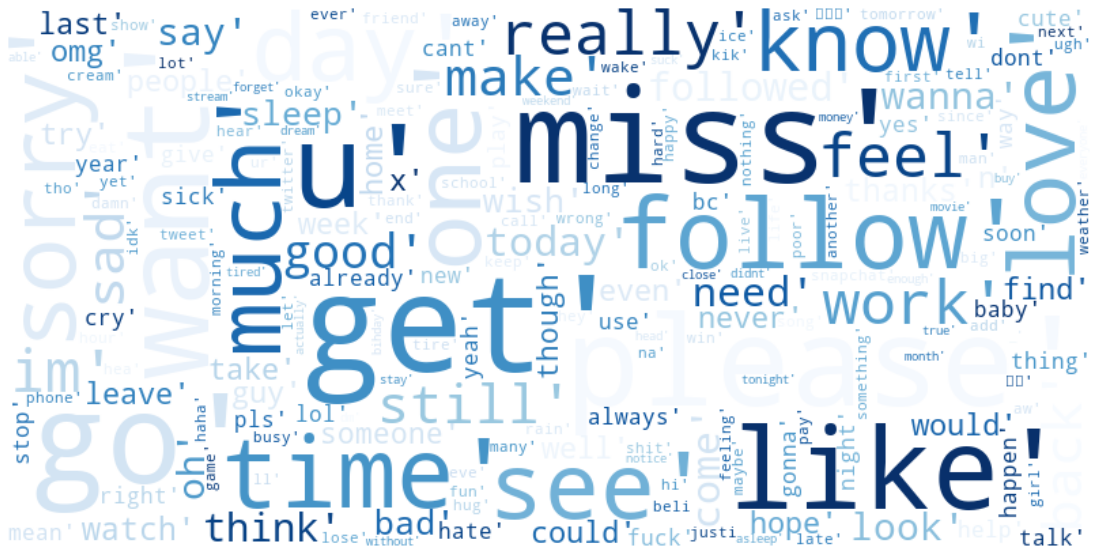

In [61]:
from wordcloud import WordCloud

neg_tweets = ''.join(str(v) for v in clean_negative)

WordCloud = WordCloud(width = 800, height = 400,colormap="Blues",
                      background_color='white', random_state = 21, max_font_size = 100, collocations = False).generate(neg_tweets)

plt.figure(figsize = (20,10))
plt.imshow(WordCloud, interpolation = 'bilinear')
plt.axis('off')

In [138]:
def data_prepare(tokens, status):
    featureset = [(tweet, status) for tweet in tokens]
    return featureset

In [139]:
positive_featureset = data_prepare(clean_positive, 'Positive')
negative_featureset = data_prepare(clean_negative, 'Negative')

featureset = positive_featureset + negative_featureset
featureset[-5:]


[(['wanna', 'change', 'avi', 'usanele', '('], 'Negative'),
 (['puppy', 'broke', 'foot', '('], 'Negative'),
 (["where's", 'jaebum', 'baby', 'picture', '(', '('], 'Negative'),
 (['mr', 'ahmad', 'maslan', 'cook', '('], 'Negative'),
 (['hull', 'suppoer', 'expect', 'misserable', 'week', '-('], 'Negative')]

In [140]:
features =[]
labels = []

for x in featureset:
    features.append(x[0])
    labels.append(x[1])
    
print(features[0])
print(labels[0])


['top', 'engage', 'member', 'community', 'week', ')']
Positive


In [141]:
print(features[-1])
print(labels[-1])

['hull', 'suppoer', 'expect', 'misserable', 'week', '-(']
Negative


In [142]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range = (1, 2), sublinear_tf = True, max_features = 3000, preprocessor = ' '.join)
vectorized_features = vectorizer.fit_transform(features)

In [143]:
vocabulary = vectorizer.get_feature_names_out()
print(vocabulary[:15])
print(len(vocabulary))


['ab' 'able' 'able see' 'abroad' 'absolute' 'absolutely' 'abt' 'acc'
 'access' 'account' 'across' 'act' 'act like' 'active' 'actually']
3000


In [144]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vectorized_features, labels, test_size = 0.15, shuffle = True)


In [145]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators = 500)
classifier = text_classifier.fit(X_train, y_train)

In [347]:
test_tweets = twitter_samples.tokenized('tweets.20150430-223406.json')
clean_test_tweets = list(map(clean_tokens, test_tweets))

print(test_tweets[0])
print(clean_test_tweets[0])

['RT', '@KirkKus', ':', 'Indirect', 'cost', 'of', 'the', 'UK', 'being', 'in', 'the', 'EU', 'is', 'estimated', 'to', 'be', 'costing', 'Britain', '£', '170', 'billion', 'per', 'year', '!', '#BetterOffOut', '#UKIP']
['indirect', 'cost', 'uk', 'eu', 'estimate', 'cost', 'britain', '£', 'billion', 'per', 'year']


In [348]:
pd.set_option('max_colwidth', 1000)

df = pd.DataFrame()
df['Tweets'] = clean_test_tweets
df['Sentiment'] = classifier.predict(vectorizer.transform(list(clean_test_tweets)))
df.head(10)

,Tweets,Sentiment
0,"[indirect, cost, uk, eu, estimate, cost, britain, £, billion, per, year]",Positive
1,"[video, sturgeon, post-election, deal]",Positive
2,"[economy, grow, time, faster, day, david, cameron, become, prime, minister, today]",Negative
3,"[ukip, east, lothian, candidate, look, still, msn, addy]",Negative
4,"[ukip's, housing, spokesman, rake, £, k, housing, benefit, migrant]",Negative
5,"[make, sure, tune, tonight, bbc]",Positive
6,"[ed, milliband, embarrassment, would, want, represent, uk, vote]",Negative
7,"[ft, back, tory, unrelated, note, here's, photo, ft, leader, writer, jonathan, ford, (, next, boris, )]",Positive
8,"[“, ed, miliband, prove, tonight, he's, job, ”, tbf, spend, year, salivate, …]",Positive
9,"[lolz, trickle, wealth, never, trickle, past, wallet, greed, always, win, greedy]",Negative


# Implementation of Random forest, Naive Bayes and SVM Final model

In [106]:

#Import libraries

import tweepy
import pandas as pd
import numpy as np
import re
import pickle

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import twitter_samples
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import naive_bayes

from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score




In [79]:
#Download Data

nltk.download('twitter_samples', 'wordnet', 'averaged_perceptron_tagger')



True

In [80]:
positive_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tokens = twitter_samples.tokenized('negative_tweets.json')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range = (1, 2), sublinear_tf = True, max_features = 3000, preprocessor = ' '.join)
vectorized_features = vectorizer.fit_transform(features)

In [104]:
#Custom functions

def clean_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    clean_list = []
    for token, tag in pos_tag(tokens):
        token = token.lower()
        token = re.sub(r'@[a-z0-9_]\S+', '', token)
        token = re.sub(r'#[a-z0-9_]\S+', '', token)
        token = re.sub(r'&[a-z0-9_]\S+', '', token)
        token = re.sub(r'[?!.+,;:$%&"]+', '', token)
        token = re.sub(r'rt[\s]+', '', token)
        token = re.sub(r'\d+', '', token)
        token = re.sub(r'\$+', '', token)
        token = re.sub(r'rt+' , '', token)
        token = re.sub(r'https?:?\/\/\S+', '', token)
        if tag.startswith('NN'):
            position = 'n'
        elif tag.startswith('VB'):
            position = 'v'
        elif tag.startswith('RB'):
            position = 'r'
        elif tag.startswith('JJ'):
            position = 'a'
        else:
            position = 'n'
        clean_list.append(lemmatizer.lemmatize(token, pos = position))
        clean_list = [i for i in clean_list if i not in stop_words and len(i) > 0 and i != ':'] #removing empty space and :
    return clean_list

def data_prepare(tokens, status):
    featureset = [(tweet, status) for tweet in tokens]
    return featureset

def featureset_prepare():
    positive_featureset = data_prepare(list(map(clean_tokens, positive_tokens)), 'Positive')
    negative_featureset = data_prepare(list(map(clean_tokens, negative_tokens)), 'Negative')
    featureset = positive_featureset + negative_featureset
    
    features =[]
    labels = []

    for x in featureset:
        features.append(x[0])
        labels.append(x[1])
    return features, labels


#Random Forest 
def train_model():
    rf_vectorizer = TfidfVectorizer(ngram_range = (1, 2), sublinear_tf = True, max_features = 3000, preprocessor = ' '.join)
    vectorized_features = rf_vectorizer.fit_transform(featureset_prepare()[0])
    
    X_train, X_test, y_train, y_test = train_test_split(vectorized_features, featureset_prepare()[1], 
                                                        test_size = 0.15, shuffle = True)
    rf_classifier = RandomForestClassifier(n_estimators = 200)
    rf_classifier = rf_classifier.fit(X_train, y_train)
    pickle.dump(rf_classifier, open('rf_classifier', 'wb'))
    pickle.dump(rf_vectorizer, open('rf_vectorizer', 'wb'))
    print('Successfully saved RF classifier and vectorizer')
    

#Naive Bayes    
def train_naive():
    nb_vectorizer = TfidfVectorizer(ngram_range = (1, 2), sublinear_tf = True, max_features = 3000, preprocessor = ' '.join)
    nb_vectorized_features = nb_vectorizer.fit_transform(featureset_prepare()[0])
    
    X_train, X_test, y_train, y_test = train_test_split(nb_vectorized_features, featureset_prepare()[1], 
                                                        test_size = 0.15, shuffle = True)
    nb_classifier = naive_bayes.MultinomialNB()
    nb_classifier = nb_classifier.fit(X_train, y_train)
    pickle.dump(nb_classifier, open('nb_classifier', 'wb'))
    pickle.dump(nb_vectorizer, open('nb_vectorizer', 'wb'))
    print('Successfully saved NB classifier and vectorizer')
    

#SVM
def train_SVM():
    # Perform classification with SVM, kernel=linear
    svm_vectorizer = TfidfVectorizer(ngram_range = (1, 2), sublinear_tf = True, max_features = 3000, preprocessor = ' '.join)
    svm_vectorized_features = svm_vectorizer.fit_transform(featureset_prepare()[0])

    X_train, X_test, y_train, y_test = train_test_split(svm_vectorized_features, featureset_prepare()[1], 
                                                        test_size = 0.15, shuffle = True)
    svm_classifier = svm.SVC(kernel='linear')
    svm_classifier = svm_classifier.fit(X_train, y_train)
    pickle.dump(svm_classifier, open('svm_classifier', 'wb'))
    pickle.dump(svm_vectorizer, open('svm_vectorizer', 'wb'))
    print('Successfully saved SVM classifier and vectorizer')


#Function to evaluate the models

def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    


In [236]:
#Execute
train_model()
train_naive()
train_SVM()


Successfully saved RF classifier and vectorizer
Successfully saved NB classifier and vectorizer
Successfully saved SVM classifier and vectorizer


Random Forest model result

Accuracy Score:  0.9315 

              precision    recall  f1-score   support

    Negative       0.92      0.95      0.93      1008
    Positive       0.95      0.91      0.93       992

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



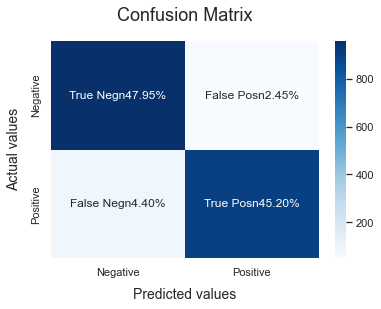

In [267]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score

rf_classifier = pickle.load(open('rf_classifier', 'rb'))
rf_predictions = rf_classifier.predict(X_test)
print("Random Forest model result\n")
print("Accuracy Score: ",accuracy_score(y_test, rf_predictions),"\n")
model_Evaluate(rf_classifier)


In [183]:
rf_classifier = pickle.load(open('rf_classifier', 'rb'))
rf_predictions = rf_classifier.predict(X_test)
rf_acc= accuracy_score(y_test, rf_predictions)

nb_classifier = pickle.load(open('nb_classifier', 'rb'))
nb_predictions = nb_classifier.predict(X_test)
nb_acc= accuracy_score(y_test, nb_predictions)

svm_classifier = pickle.load(open('svm_classifier', 'rb'))
svm_predictions = svm_classifier.predict(X_test)
svm_acc= accuracy_score(y_test, svm_predictions)

Multinomial Naive Bayes model result
Accuracy Score:  0.806 

              precision    recall  f1-score   support

    Negative       0.79      0.82      0.81       731
    Positive       0.83      0.79      0.81       769

    accuracy                           0.81      1500
   macro avg       0.81      0.81      0.81      1500
weighted avg       0.81      0.81      0.81      1500



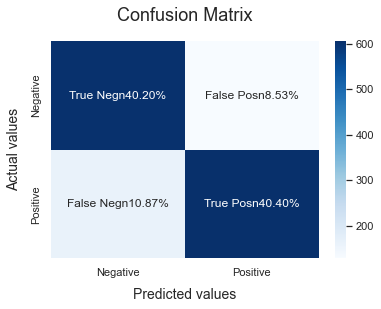

In [108]:
nb_classifier = pickle.load(open('nb_classifier', 'rb'))
nb_predictions = nb_classifier.predict(X_test)
print("Multinomial Naive Bayes model result")
print("Accuracy Score: ",accuracy_score(y_test, nb_predictions),"\n")
model_Evaluate(nb_classifier)

Support Vector Machine model result
Accuracy Score:  0.814 

              precision    recall  f1-score   support

    Negative       0.77      0.87      0.82       731
    Positive       0.86      0.76      0.81       769

    accuracy                           0.81      1500
   macro avg       0.82      0.82      0.81      1500
weighted avg       0.82      0.81      0.81      1500



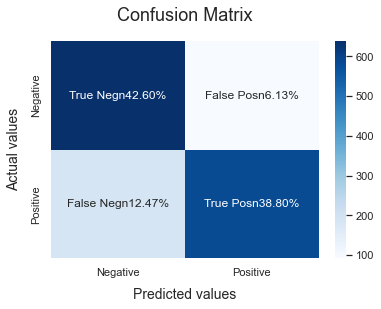

In [107]:
svm_classifier = pickle.load(open('svm_classifier', 'rb'))
svm_predictions = svm_classifier.predict(X_test)
print("Support Vector Machine model result")
print("Accuracy Score: ",accuracy_score(y_test, svm_predictions),"\n")
model_Evaluate(svm_classifier)

# Testing models on real time tweets 

In [149]:
#Import libraries

import tweepy
import pandas as pd
import numpy as np
import re
import pickle

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import twitter_samples
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import naive_bayes

from sklearn import svm
from sklearn.metrics import classification_report


In [150]:
#Testing real time tweets

def clean_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    clean_list = []
    for token, tag in pos_tag(tokens):
        token = token.lower()
        token = re.sub(r'@[a-z0-9_]\S+', '', token)
        token = re.sub(r'#[a-z0-9_]\S+', '', token)
        token = re.sub(r'&[a-z0-9_]\S+', '', token)
        token = re.sub(r'[?!.+,;:$%&"]+', '', token)
        token = re.sub(r'rt[\s]+', '', token)
        token = re.sub(r'\d+', '', token)
        token = re.sub(r'\$+', '', token)
        token = re.sub(r'rt+' , '', token)
        token = re.sub(r'https?:?\/\/\S+', '', token)
        if tag.startswith('NN'):
            position = 'n'
        elif tag.startswith('VB'):
            position = 'v'
        elif tag.startswith('RB'):
            position = 'r'
        elif tag.startswith('JJ'):
            position = 'a'
        else:
            position = 'n'
        clean_list.append(lemmatizer.lemmatize(token, pos = position))
        clean_list = [i for i in clean_list if i not in stop_words and len(i) > 0 and i != ':'] #removing empty space and :
    return clean_list

def vader_compound_score(tweet):
    vader = SentimentIntensityAnalyzer()
    if vader.polarity_scores(tweet)['compound'] >= 0.05:
        return 'Positive'
    elif vader.polarity_scores(tweet)['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
    
def textblob_sentiment(tweet):
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'
    
def rf_sentiment(tweet):
    rf_classifier = pickle.load(open('rf_classifier', 'rb'))
    rf_vectorizer = pickle.load(open('rf_vectorizer', 'rb'))
    
    return classifier.predict(rf_vectorizer.transform(list(tweet)))


def nb_sentiment(tweet):
    nb_classifier = pickle.load(open('nb_classifier', 'rb'))
    nb_vectorizer = pickle.load(open('nb_vectorizer', 'rb'))
    
    return nb_classifier.predict(nb_vectorizer.transform(list(tweet)))

def svm_sentiment(tweet):
    svm_classifier = pickle.load(open('svm_classifier', 'rb'))
    svm_vectorizer = pickle.load(open('svm_vectorizer', 'rb'))
    
    return svm_classifier.predict(svm_vectorizer.transform(list(tweet)))



In [153]:
key_word = 'review'
limit = 9000

def tweet_search(key_word):
    i = 0
    tweets_df = pd.DataFrame(columns = ['Datetime', 'Tweet'])
    for tweet in tweepy.Cursor(api.search_tweets, q = key_word, count = 100, lang = 'en', tweet_mode = 'extended').items():
        print('Tweets downloaded:', i, '/', limit, end = '\r')
        if tweet.user.followers_count > 500:
            tweet_tokenizer = TweetTokenizer()
            tweets_df = tweets_df.append({'Datetime': tweet.created_at, 'Tweet':tweet.full_text,
                                          'Tokenised Tweet': tweet_tokenizer.tokenize(tweet.full_text)}, 
                                          ignore_index = True)
            i += 1
        if i>= limit:
            break
        else:
            pass
    tweets_df['Datetime'] = pd.to_datetime(tweets_df['Datetime'], format = '%Y.%m.%d %H:%M:%S')
    tweets_df.set_index('Datetime' ,inplace = True)
    tweets_df['CleanTweet'] = tweets_df['Tokenised Tweet'].apply(clean_tokens)
    tweets_df['RF_sent'] = rf_sentiment(tweets_df['CleanTweet'])
    
    tweets_df['NB_sent'] = nb_sentiment(tweets_df['CleanTweet'])
    
    tweets_df['SVM_sent'] = nb_sentiment(tweets_df['CleanTweet'])

    
    tweets_df['CleanTweet'] = [', '.join(map(str, token)) for token in tweets_df['CleanTweet']]
    tweets_df.drop_duplicates(subset = ['CleanTweet'], inplace = True)
    tweets_df['Vader_sent'] = tweets_df['CleanTweet'].apply(vader_compound_score)
    tweets_df['TextBlob_sent'] = tweets_df['CleanTweet'].apply(textblob_sentiment)
    
   
    
    #tweets_df.to_csv(key_word + '.csv', encoding = 'utf-8')
    return tweets_df

In [154]:
tweets_df = tweet_search(key_word)
tweets_df

Rate limit reached. Sleeping for: 328


,Tweet,Tokenised Tweet,CleanTweet,RF_sent,NB_sent,SVM_sent,Vader_sent,TextBlob_sent
Datetime,,,,,,,,
2023-01-09 15:32:52+00:00,RT @CVR_TomaszGuzik: In the #NET 🥅\n\nMust-rea...,"[RT, @CVR_TomaszGuzik, :, In, the, #NET, 🥅, Mu...","🥅, must-read, review, neutrophil, extracellula...",Positive,Positive,Positive,Negative,Neutral
2023-01-09 15:32:49+00:00,RT @kyledcheney: There are some eye-opening pr...,"[RT, @kyledcheney, :, There, are, some, eye-op...","eye-opening, provision, text, gop, ’, propose,...",Positive,Positive,Positive,Neutral,Neutral
2023-01-09 15:32:47+00:00,RT @BuckeyefromMich: Dr. Renault's Secret :: H...,"[RT, @BuckeyefromMich, :, Dr, ., Renault's, Se...","dr, renault's, secret, horror, review, via, …",Positive,Positive,Positive,Negative,Negative
2023-01-09 15:32:47+00:00,"COBRA AEROJET Driver Review (Max, Standard &am...","[COBRA, AEROJET, Driver, Review, (, Max, ,, St...","cobra, aerojet, driver, review, (, max, standa...",Positive,Negative,Negative,Neutral,Neutral
2023-01-09 15:32:45+00:00,RT @IANAuthorsBooks: Hello Hollywood! “Vividly...,"[RT, @IANAuthorsBooks, :, Hello, Hollywood, !,...","hello, hollywood, “, vividly, detail, historic...",Positive,Positive,Positive,Neutral,Positive
...,...,...,...,...,...,...,...,...
2023-01-09 11:48:14+00:00,To eliminate human error I need systems.\n\nTh...,"[To, eliminate, human, error, I, need, systems...","eliminate, human, error, need, system, system,...",Negative,Positive,Positive,Negative,Neutral
2023-01-09 11:48:13+00:00,RT @ArmonWright1: clips from the camp i got th...,"[RT, @ArmonWright1, :, clips, from, the, camp,...","clip, camp, get, review",Negative,Negative,Negative,Neutral,Neutral
2023-01-09 11:48:05+00:00,Python Fundamentals Review: Part 2 - https://t...,"[Python, Fundamentals, Review, :, Part, 2, -, ...","python, fundamental, review, pa, -",Positive,Positive,Positive,Neutral,Neutral


In [155]:
#tweets_df.to_csv(key_word + '.csv', encoding = 'utf-8')

In [438]:
tweets_df

,Tweet,Username,Retweets,Followers,CleanTweet,Vader_sentiment,TextBlob_sentiment,Different_sentiment,senLen
Datetime,,,,,,,,,
2023-01-03 00:52:06+00:00,"RT @JudithArnopp: 'For anyone who loves fantastic historical fiction, this one's for you. I'll chuck it up to being one of my best reads th…",1BrookAllen,8,7410,"', for, anyone, who, loves, fantastic, historical, fiction, this, one's, for, you, i'll, chuck, it, up, to, being, one, of, my, best, reads, th, …",Positive,Positive,0,140
2023-01-03 00:52:05+00:00,4 of 5 stars to Birthday Letters by Ted Hughes https://t.co/TTHxbIAbgS,ElleLaMarca,0,586,"of, stars, to, bihday, letters, by, ted, hughes",Neutral,Neutral,0,70
2023-01-03 00:52:03+00:00,"RT @IzzraifHarz: saying ""kuah pekat, portion besar, semua sedap"" is probably the lowest form of food review. i wouldn't trust you if you al…",Amir_Cyclone,2030,790,"saying, kuah, pekat, poion, besar, semua, sedap, is, probably, the, lowest, form, of, food, review, i, wouldn't, trust, you, if, you, al, …",Negative,Neutral,1,140
2023-01-03 00:52:01+00:00,"RT @DiscussingFilm: ‘AVATAR: THE WAY OF WATER’ actually earned $66.8M in the film’s third weekend domestically, a 6% increase from last wee…",Samii_UTD,620,3555,"‘, avatar, the, way, of, water, ’, actually, earned, m, in, the, film, ’, s, third, weekend, domestically, a, increase, from, last, wee, …",Positive,Neutral,1,140
2023-01-03 00:52:00+00:00,"RT @rasbt: ""Ahead of AI #4: A Big Year For AI"" is out!\n\nIn this issue I'm discussing:\n- My top 10 papers I read this year\n- AI industry tre…",theWordofMentor,43,577,"ahead, of, ai, a, big, year, for, ai, is, out, in, this, issue, i'm, discussing, -, my, top, papers, i, read, this, year, -, ai, industry, tre, …",Positive,Positive,0,140
...,...,...,...,...,...,...,...,...,...
2023-01-02 20:48:08+00:00,"Year In Review: Video: The Watch I Wore Most In 2022, By Members Of The Hodinkee Family https://t.co/cWc2jtgRnb | @Hodinkee #YearInReview #AllThingsWatches #WatchCollecting #Hodinkee https://t.co/hwp5JDnyOU",RunnymedeCap,1,14344,"year, in, review, video, the, watch, i, wore, most, in, by, members, of, the, hodinkee, family, |",Neutral,Positive,1,206
2023-01-02 20:48:08+00:00,"@SufianMughal13 make sure that your upload follows our advertiser-friendly content guidelines: https://t.co/TuvjClh5kx if you already requested for a manual review, it can take up to 7 days: https://t.co/06GvwyyjJ1 lmk if you need anything else!",TeamYouTube,0,1533828,"make, sure, that, your, upload, follows, our, adveiser-friendly, content, guidelines, if, you, already, requested, for, a, manual, review, it, can, take, up, to, days, lmk, if, you, need, anything, else",Positive,Positive,0,245
2023-01-02 20:48:06+00:00,That independent pay review body looks less independent every day. #NursesStrike #NHSCrisis #NHSStrikes #NHS #nhsisbroken #ToriesDestroyingOurCountry #ToriesUnfitToGovern #ToriesDestroyingOurNHS https://t.co/jhrwXqLcGV,vampyr131,0,2803,"that, independent, pay, review, body, looks, less, independent, every, day",Negative,Negative,0,218


# Testing models on labelled data to get accuracy of TextBlob and VADER

In [156]:


positive_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tokens = twitter_samples.tokenized('negative_tweets.json')

def clean_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    clean_list = []
    for token, tag in pos_tag(tokens):
        token = token.lower()
        token = re.sub(r'@[a-z0-9_]\S+', '', token)
        token = re.sub(r'#[a-z0-9_]\S+', '', token)
        token = re.sub(r'&[a-z0-9_]\S+', '', token)
        token = re.sub(r'[?!.+,;:$%&"]+', '', token)
        token = re.sub(r'rt[\s]+', '', token)
        token = re.sub(r'\d+', '', token)
        token = re.sub(r'\$+', '', token)
        token = re.sub(r'rt+' , '', token)
        token = re.sub(r'https?:?\/\/\S+', '', token)
        if tag.startswith('NN'):
            position = 'n'
        elif tag.startswith('VB'):
            position = 'v'
        elif tag.startswith('RB'):
            position = 'r'
        elif tag.startswith('JJ'):
            position = 'a'
        else:
            position = 'n'
        clean_list.append(lemmatizer.lemmatize(token, pos = position))
        clean_list = [i for i in clean_list if i not in stop_words and len(i) > 0 and i != ':'] #removing empty space and :
    return clean_list

def data_prepare(tokens, status):
    featureset = [(tweet, status) for tweet in tokens]
    return featureset

def featureset_prepare():
    positive_featureset = data_prepare(list(map(clean_tokens, positive_tokens)), 'Positive')
    negative_featureset = data_prepare(list(map(clean_tokens, negative_tokens)), 'Negative')
    featureset = positive_featureset + negative_featureset
    
    features = []
    labels = []
    
    for x in featureset:
        features.append(x[0])
        labels.append(x[1])
    return features,labels

def vader_compound_score(tweet):
    vader = SentimentIntensityAnalyzer()
    if vader.polarity_scores(tweet)['compound'] >= 0.05:
        return 'Positive'
    elif vader.polarity_scores(tweet)['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
    
def textblob_sentiment(tweet):
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'
    
def rf_sentiment(tweet):
    classifier = pickle.load(open('rf_classifier', 'rb'))
    vectorizer = pickle.load(open('rf_vectorizer', 'rb'))
    
    return classifier.predict(vectorizer.transform(list(tweet)))



In [157]:
features = featureset_prepare()[0]
labels = featureset_prepare()[1]



In [158]:
print(features[1])
print(labels[1])
print(features[-1])
print(labels[-1])

['hey', 'james', 'odd', '/', 'please', 'call', 'contact', 'centre', 'able', 'assist', ')', 'many', 'thanks']
Positive
['hull', 'suppoer', 'expect', 'misserable', 'week', '-(']
Negative


In [159]:
df = pd.DataFrame(columns =['Tweet', 'Real_sent'])
df['Tweet'] = pd.Series(features).values
df['Real_sent'] = pd.Series(labels).values
df

,Tweet,Real_sent
0,"[top, engage, member, community, week, )]",Positive
1,"[hey, james, odd, /, please, call, contact, ce...",Positive
2,"[listen, last, night, ), bleed, amazing, track...",Positive
3,"[congrats, )]",Positive
4,"[yeaaaah, yippppy, accnt, verify, rqst, succee...",Positive
...,...,...
9995,"[wanna, change, avi, usanele, (]",Negative
9996,"[puppy, broke, foot, (]",Negative
9997,"[where's, jaebum, baby, picture, (, (]",Negative
9998,"[mr, ahmad, maslan, cook, (]",Negative


In [160]:
df['RandomForest'] = rf_sentiment(df['Tweet'])
dr[]
df['Tweet'] = [', '.join(map(str, token)) for token in df['Tweet']]
df['Vader'] = df['Tweet'].apply(vader_compound_score)
df['TextBlob'] = df['Tweet'].apply(textblob_sentiment)
df

,Tweet,Real_sent,RandomForest,Vader,TextBlob
0,"top, engage, member, community, week, )",Positive,Positive,Positive,Positive
1,"hey, james, odd, /, please, call, contact, cen...",Positive,Positive,Positive,Positive
2,"listen, last, night, ), bleed, amazing, track,...",Positive,Positive,Positive,Positive
3,"congrats, )",Positive,Positive,Positive,Neutral
4,"yeaaaah, yippppy, accnt, verify, rqst, succeed...",Positive,Positive,Positive,Neutral
...,...,...,...,...,...
9995,"wanna, change, avi, usanele, (",Negative,Negative,Neutral,Neutral
9996,"puppy, broke, foot, (",Negative,Negative,Negative,Neutral
9997,"where's, jaebum, baby, picture, (, (",Negative,Negative,Neutral,Neutral
9998,"mr, ahmad, maslan, cook, (",Negative,Negative,Neutral,Neutral


In [161]:
df['TB_accuracy'] = np.where(df['Real_sent'] == df['TextBlob'], 1, 0)
df['VA_accuracy'] = np.where(df['Real_sent'] == df['Vader'], 1, 0)
df['RF_accuracy'] = np.where(df['Real_sent'] == df['RandomForest'], 1, 0)
df

,Tweet,Real_sent,RandomForest,Vader,TextBlob,TB_accuracy,VA_accuracy,RF_accuracy
0,"top, engage, member, community, week, )",Positive,Positive,Positive,Positive,1,1,1
1,"hey, james, odd, /, please, call, contact, cen...",Positive,Positive,Positive,Positive,1,1,1
2,"listen, last, night, ), bleed, amazing, track,...",Positive,Positive,Positive,Positive,1,1,1
3,"congrats, )",Positive,Positive,Positive,Neutral,0,1,1
4,"yeaaaah, yippppy, accnt, verify, rqst, succeed...",Positive,Positive,Positive,Neutral,0,1,1
...,...,...,...,...,...,...,...,...
9995,"wanna, change, avi, usanele, (",Negative,Negative,Neutral,Neutral,0,0,1
9996,"puppy, broke, foot, (",Negative,Negative,Negative,Neutral,0,1,1
9997,"where's, jaebum, baby, picture, (, (",Negative,Negative,Neutral,Neutral,0,0,1
9998,"mr, ahmad, maslan, cook, (",Negative,Negative,Neutral,Neutral,0,0,1


In [219]:
print('Accuracy of TextBlob approach is:', (len(df[df['TB_accuracy'] == 1]) / len(df)) * 100,'%')
text_acc=(len(df[df['TB_accuracy'] == 1]) / len(df))
print('Accuracy of Vader approach is:', (len(df[df['VA_accuracy'] == 1]) / len(df)) * 100,'%')
vader_acc=(len(df[df['VA_accuracy'] == 1]) / len(df))
print('Accuracy of Random Forest approach is:', (len(df[df['RF_accuracy'] == 1]) / len(df)) * 100,'%')

Accuracy of TextBlob approach is: 36.22 %
Accuracy of Vader approach is: 45.050000000000004 %
Accuracy of Random Forest approach is: 92.72 %


# Implementation and testing of BiLSTM model

In [264]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd

In [265]:
import json
from nltk.corpus import twitter_samples
twitter_samples.fileids()

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']

In [266]:
positive_tweets=[]
strings = twitter_samples.strings('positive_tweets.json')
for string in strings:
    positive_tweets.append(string)

In [267]:
positive_tweets

['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)',
 '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
 '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!',
 '@97sides CONGRATS :)',
 'yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days',
 '@BhaktisBanter @PallaviRuhail This one is irresistible :)\n#FlipkartFashionFriday http://t.co/EbZ0L2VENM',
 "We don't like to keep our lovely customers waiting for long! We hope you enjoy! Happy Friday! - LWWF :) https://t.co/smyYriipxI",
 '@Impatientraider On second thought, there’s just not enough time for a DD :) But new shorts entering system. Sheep must be buying.',
 'Jgh , but we have to go to Bayan :D bye',
 'As an act of mischievousness, am calling the ETL layer of our in-house warehousing 

In [268]:
negative_tweets=[]
strings = twitter_samples.strings('negative_tweets.json')
for string in strings:
    negative_tweets.append(string)

In [269]:
negative_tweets

['hopeless for tmr :(',
 "Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(",
 '@Hegelbon That heart sliding into the waste basket. :(',
 '“@ketchBurning: I hate Japanese call him "bani" :( :(”\n\nMe too',
 'Dang starting next week I have "work" :(',
 "oh god, my babies' faces :( https://t.co/9fcwGvaki0",
 '@RileyMcDonough make me smile :((',
 '@f0ggstar @stuartthull work neighbour on motors. Asked why and he said hates the updates on search :( http://t.co/XvmTUikWln',
 'why?:("@tahuodyy: sialan:( https://t.co/Hv1i0xcrL2"',
 'Athabasca glacier was there in #1948 :-( #athabasca #glacier #jasper #jaspernationalpark #alberta #explorealberta #… http://t.co/dZZdqmf7Cz',
 "I have a really good m&amp;g idea but I'm never going to meet them :(((",
 '@Rampageinthebox mare ivan :(',
 '@SophiaMascardo happy trip, keep safe. see you soon :* :(',
 "I'm so tired hahahah :(",
 '@GrumpyCockney With knee replacements they get you up &amp; about the same day. :-(   Ou

In [270]:
def data_prepare(pos_neg_tweets, status):
    featureset = [(tweet, status) for tweet in pos_neg_tweets]
    return featureset

In [271]:
positive_featureset = data_prepare(positive_tweets, 'Positive')
negative_featureset = data_prepare(negative_tweets, 'Negative')

featureset = positive_featureset + negative_featureset
featureset[5:]

[('@BhaktisBanter @PallaviRuhail This one is irresistible :)\n#FlipkartFashionFriday http://t.co/EbZ0L2VENM',
  'Positive'),
 ("We don't like to keep our lovely customers waiting for long! We hope you enjoy! Happy Friday! - LWWF :) https://t.co/smyYriipxI",
  'Positive'),
 ('@Impatientraider On second thought, there’s just not enough time for a DD :) But new shorts entering system. Sheep must be buying.',
  'Positive'),
 ('Jgh , but we have to go to Bayan :D bye', 'Positive'),
 ('As an act of mischievousness, am calling the ETL layer of our in-house warehousing app Katamari.\n\nWell… as the name implies :p.',
  'Positive'),
 ('#FollowFriday @wncer1 @Defense_gouv for being top influencers in my community this week :)',
  'Positive'),
 ("Who Wouldn't Love These Big....Juicy....Selfies :) - http://t.co/QVzjgd1uFo http://t.co/oWBL11eQRY",
  'Positive'),
 ('@Mish23615351  follow @jnlazts &amp; http://t.co/RCvcYYO0Iq follow u back :)',
  'Positive'),
 ("@jjulieredburn Perfect, so you already

In [272]:
features =[]
labels = []

for x in featureset:
    features.append(x[0])
    labels.append(x[1])
    
print(features[0])
print(labels[0])

#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Positive


In [273]:
#pd.set_option('max_colwidth', 1000)

df1 = pd.DataFrame()
df1['tweets'] = features
df1['sentiment'] = labels
df1.head(-10)

,tweets,sentiment
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,Positive
1,@Lamb2ja Hey James! How odd :/ Please call our...,Positive
2,@DespiteOfficial we had a listen last night :)...,Positive
3,@97sides CONGRATS :),Positive
4,yeaaaah yippppy!!! my accnt verified rqst has...,Positive
...,...,...
9985,@PulkitSamrat @yamigautam that is unfair ..why...,Negative
9986,@LucyAndLydia @georgiamerryyy I want one :(,Negative
9987,Feel sick :(,Negative
9988,Hmmm 10 mins to get my train and I'm currently...,Negative


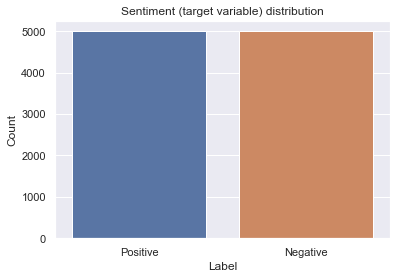

In [20]:
sns.set(style="darkgrid")
b = sns.countplot(x='sentiment',
                  data = df1.drop(['tweets'], axis=1))
b.axes.set_title('Sentiment (target variable) distribution')
b.set_xlabel("Label")
b.set_ylabel("Count")
plt.show()

In [274]:
#Cleaning tweets

def TextClean(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'@[a-z0-9_]\S+', '', tweet)
    tweet = re.sub(r'#[a-z0-9_]\S+', '', tweet)
    tweet = re.sub(r'&[a-z0-9_]\S+', '', tweet)
    tweet = re.sub(r'[?!.+,;:$%&"]+', '', tweet)
    tweet = re.sub(r'rt[\s]+', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    tweet = re.sub(r'\$+', '', tweet)
    tweet = re.sub(r'rt+' , '', tweet)
    tweet = re.sub(r'https?:?\/\/\S+', '', tweet)
    
    return tweet

In [275]:
temp = []
#Splitting pd.Series to list
data_to_list = df1['tweets'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(TextClean(data_to_list[i]))
list(temp[:5])

['    for being top engaged members in my community this week )',
 ' hey james how odd / please call our contact centre on  and we will be able to assist you ) many thanks',
 ' we had a listen last night ) as you bleed is an amazing track when are you in scotland',
 ' congrats )',
 'yeaaaah yippppy  my accnt verified rqst has succeed got a blue tick mark on my fb profile ) in  days']

In [276]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week'], ['hey', 'james', 'how', 'odd', 'please', 'call', 'our', 'contact', 'centre', 'on', 'and', 'we', 'will', 'be', 'able', 'to', 'assist', 'you', 'many', 'thanks'], ['we', 'had', 'listen', 'last', 'night', 'as', 'you', 'bleed', 'is', 'an', 'amazing', 'track', 'when', 'are', 'you', 'in', 'scotland'], ['congrats'], ['yeaaaah', 'yippppy', 'my', 'accnt', 'verified', 'rqst', 'has', 'succeed', 'got', 'blue', 'tick', 'mark', 'on', 'my', 'fb', 'profile', 'in', 'days'], ['this', 'one', 'is', 'irresistible'], ['we', 'don', 'like', 'to', 'keep', 'our', 'lovely', 'customers', 'waiting', 'for', 'long', 'we', 'hope', 'you', 'enjoy', 'happy', 'friday', 'lwwf'], ['on', 'second', 'thought', 'there', 'just', 'not', 'enough', 'time', 'for', 'dd', 'but', 'new', 'shos', 'entering', 'system', 'sheep', 'must', 'be', 'buying'], ['jgh', 'but', 'we', 'have', 'to', 'go', 'to', 'bayan', 'bye'], ['as', 'an', 'act', 'of', 'mischievo

In [277]:
len(data_words)

10000

In [278]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [279]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['for being top engaged members in my community this week', 'hey james how odd please call our contact centre on and we will be able to assist you many thanks', 'we had listen last night as you bleed is an amazing track when are you in scotland', 'congrats', 'yeaaaah yippppy my accnt verified rqst has succeed got blue tick mark on my fb profile in days']


In [280]:
data = np.array(data)


In [281]:
#Label encoding


import tensorflow as tf
labels1 = np.array(df1['sentiment'])
y = []
for i in range(len(labels1)):
    if labels1[i] == 'Negative':
        y.append(0)
    if labels1[i] == 'Positive':
        y.append(1)
y = np.array(y)
labels1 = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [282]:
len(labels1)

10000

In [283]:
# Data sequencing and splitting

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Embedding
embedding_layer = Embedding(1000, 64)
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  373   16  116]
 [   0    0    0 ...    1  205   21]
 [   0    0    0 ...    1    9 1650]
 ...
 [   0    0    0 ...    3  198  881]
 [   0    0    0 ...   17  748   35]
 [   0    0    0 ... 2562  297  393]]


In [284]:
print(labels1)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [285]:
#Splitting the data
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(tweets,labels1, random_state=0)
print (len(X_train_l),len(X_test_l),len(y_train_l),len(y_test_l))

7500 2500 7500 2500


In [491]:
# model building Single layer LSTM


model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/70
235/235 [==============================] - ETA: 0s - loss: 0.7481 - accuracy: 0.5525
Epoch 1: val_accuracy improved from -inf to 0.55440, saving model to best_model1.hdf5
235/235 [==============================] - 17s 61ms/step - loss: 0.7481 - accuracy: 0.5525 - val_loss: 0.6761 - val_accuracy: 0.5544
Epoch 2/70
235/235 [==============================] - ETA: 0s - loss: 0.6019 - accuracy: 0.6855
Epoch 2: val_accuracy improved from 0.55440 to 0.73640, saving model to best_model1.hdf5
235/235 [==============================] - 14s 60ms/step - loss: 0.6019 - accuracy: 0.6855 - val_loss: 0.5413 - val_accuracy: 0.7364
Epoch 3/70
235/235 [==============================] - ETA: 0s - loss: 0.5172 - accuracy: 0.7456
Epoch 3: val_accuracy improved from 0.73640 to 0.75120, saving model to best_model1.hdf5
235/235 [==============================] - 16s 69ms/step - loss: 0.5172 - accuracy: 0.7456 - val_loss: 0.5038 - val_accuracy: 0.7512
Epoch 4/70
235/235 [=============================

In [286]:
# model building Bidirectional layer LSTM


model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto',
                              period=1,save_weights_only=False, validation_split= 0.2)
lstm_history = model2.fit(X_train_l, y_train_l, epochs=70,validation_data=(X_test_l, y_test_l),callbacks=[checkpoint2])

Epoch 1/70
235/235 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.5581
Epoch 1: val_accuracy improved from -inf to 0.67640, saving model to best_model2.hdf5
235/235 [==============================] - 25s 90ms/step - loss: 0.7062 - accuracy: 0.5581 - val_loss: 0.6321 - val_accuracy: 0.6764
Epoch 2/70
235/235 [==============================] - ETA: 0s - loss: 0.5813 - accuracy: 0.6956
Epoch 2: val_accuracy improved from 0.67640 to 0.71360, saving model to best_model2.hdf5
235/235 [==============================] - 21s 91ms/step - loss: 0.5813 - accuracy: 0.6956 - val_loss: 0.5500 - val_accuracy: 0.7136
Epoch 3/70
235/235 [==============================] - ETA: 0s - loss: 0.5098 - accuracy: 0.7511
Epoch 3: val_accuracy improved from 0.71360 to 0.73440, saving model to best_model2.hdf5
235/235 [==============================] - 22s 93ms/step - loss: 0.5098 - accuracy: 0.7511 - val_loss: 0.5114 - val_accuracy: 0.7344
Epoch 4/70
235/235 [=============================

In [311]:
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 40)           200000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 3)                 123       
                                                                 
Total params: 209,883
Trainable params: 209,883
Non-trainable params: 0
_________________________________________________________________
None


In [120]:
y_lstm_pred = model2.predict(X_test_l)

79/79 [==============================] - 3s 16ms/step


In [125]:
y_lstm_pred

array([[8.5766715e-01, 1.4229335e-01, 3.9547594e-05],
       [8.9987386e-03, 9.9099851e-01, 2.6616572e-06],
       [2.0801517e-01, 7.9196799e-01, 1.6873229e-05],
       ...,
       [9.8564285e-01, 1.4344397e-02, 1.2759916e-05],
       [9.7516257e-01, 2.4824876e-02, 1.2528494e-05],
       [4.8212546e-01, 5.1783073e-01, 4.3800308e-05]], dtype=float32)

In [128]:
Y_test_lstm=[]
for i in y_test_l:
    Y_test_lstm.append(np.argmax(i))

Y_pred_lstm=[]
for i in y_lstm_pred:
    Y_pred_lstm.append(np.argmax(i))
    

Bi-lstm model accuracy:  0.7648
              precision    recall  f1-score   support

           0       0.75      0.78      0.77      1237
           1       0.78      0.75      0.76      1263

    accuracy                           0.76      2500
   macro avg       0.77      0.76      0.76      2500
weighted avg       0.77      0.76      0.76      2500



Text(0.5, 1.0, 'Confusion Matrix')

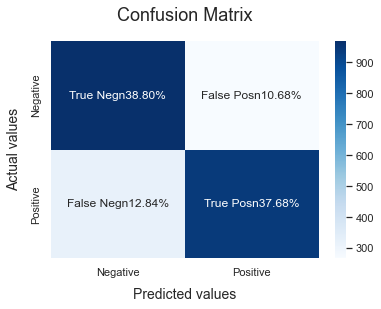

In [184]:
#Bi-Lstm Model Classification report

print("Bi-lstm model accuracy: ",accuracy_score(Y_test_lstm, Y_pred_lstm))
print(classification_report(Y_test_lstm, Y_pred_lstm))

# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(Y_test_lstm, Y_pred_lstm)
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [186]:
lstm_acc=accuracy_score(Y_test_lstm, Y_pred_lstm)

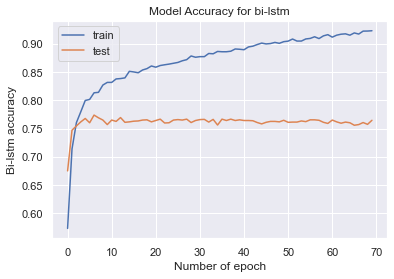

In [134]:
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('Model Accuracy for bi-lstm')
plt.ylabel('Bi-lstm accuracy')
plt.xlabel('Number of epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [287]:
#Let's load the best model obtained during training
best_model = keras.models.load_model("best_model2.hdf5")

In [250]:
max(lstm_history.history['accuracy'])

0.9233333468437195

In [176]:
sentiment = ['Negative','Positive']

In [258]:
sequence = tokenizer.texts_to_sequences(['this experience has been the worst , want my money back'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 1s 1s/step


'Negative'

In [289]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 29ms/step


'Positive'

In [291]:
sequence = tokenizer.texts_to_sequences(['i am glad it worked'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 28ms/step


'Positive'

In [260]:
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are annoying'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 27ms/step


'Negative'

In [288]:
sequence = tokenizer.texts_to_sequences(['the experience was great'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 1s 1s/step


'Positive'

In [339]:
trial_df

,Tweet,CleanTweet,RF_sent,NB_sent,SVM_sent,Vader_sent,TextBlob_sent,LSTM_sent
Datetime,,,,,,,,
2023-01-08 17:29:07+00:00,"[RT, @AgKnocks, :, New, Kyle, Ave, Out, Now, !...","new, kyle, ave, -, bobby, eff, petrino, -, joi...",Positive,Positive,Positive,Positive,Positive,Positive
2023-01-08 17:29:07+00:00,"[RT, @DiscussingFilm, :, ‘, AVATAR, :, THE, WA...","‘, avatar, way, water, ’, #, worldwide, box, o...",Positive,Positive,Positive,Neutral,Neutral,Positive
2023-01-08 17:29:06+00:00,"[This, book, is, my, first, David, Toft, exper...","book, first, david, toft, experience, honestly...",Negative,Positive,Positive,Positive,Positive,Positive
2023-01-08 17:29:04+00:00,"[Sounds, like, every, doctor, should, read, th...","sound, like, every, doctor, read, …",Positive,Positive,Positive,Positive,Positive,Positive
2023-01-08 17:29:02+00:00,"[@BTS_2015_ARMY, @Hanteo_HMAs, @Whosfan_Ofcl, ...","hi, ceain, fandom, use, vpn, voting, please, r...",Positive,Positive,Positive,Positive,Neutral,Positive
...,...,...,...,...,...,...,...,...
2023-01-08 13:01:16+00:00,"[Wigan, Athletic, are, considering, making, of...","wigan, athletic, consider, make, offer, duo, j...",Positive,Negative,Negative,Neutral,Neutral,Positive
2023-01-08 13:01:16+00:00,"[Book, review, supports, kaizen, creativity, a...","book, review, suppos, kaizen, creativity, best",Negative,Positive,Positive,Positive,Positive,Positive
2023-01-08 13:01:14+00:00,"[RT, @FishwickDavid, :, Amazing, review, and, ...","amazing, review, aicle, write, rory, kinnear, ...",Positive,Positive,Positive,Positive,Positive,Positive


In [167]:
trial_2 = pd.read_csv('review.csv')


temp2 = []
#Splitting pd.Series to list
data_to_list2 = trial_2['Tweet'].values.tolist()
for i in range(len(data_to_list2)):
    temp2.append(TextClean(data_to_list2[i]))


# def sent_to_words(sentences):
#     for sentence in sentences:
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words2 = list(sent_to_words(temp2))

#print(data_words[:10])


# def detokenize(text):
#     return TreebankWordDetokenizer().detokenize(text)

data2 = []
for i in range(len(data_words2)):
    data2.append(detokenize(data_words2[i]))
#print(data[:5])

data2 = np.array(data2)

print(data2)



['in the must read review on neutrophil extracellular traps exploring everything from the to'
 'there are some eye opening provisions in the text of the gop proposed select subcommittee on the weaponization of the'
 'dr renault secret horror review via' ... 'python fundamentals review pa'
 'thank you please give me few moments to review your file'
 'perhaps sad news that may not be handling any afar integ review classes in ue this sem it has been to years of fun and learning wish nothing but the best in your preparation for cpale looking forward to see you all in resa after graduation']


In [233]:


j=0

max_len = 200

final_df = pd.DataFrame(columns=['LSTM_sent'])
for i in data2:
    try:
        #print(i)
        sequence = tokenizer.texts_to_sequences(i)
        test2 = pad_sequences(sequence, maxlen=max_len)

        j = j+1
        final_df.loc[j] = sentiment[np.around(best_model.predict(test2), decimals=0).argmax(axis=1)[0]]
    except:
        pass


8/8 [==============================] - 0s 24ms/step


In [296]:
trial2_df = tweets_df.join(final_df)
trial2_df

,Datetime,Tweet,Tokenised Tweet,CleanTweet,RF_sent,NB_sent,SVM_sent,Vader_sent,TextBlob_sent,Lstm_sent
0,2023-01-09 15:32:52+00:00,RT @CVR_TomaszGuzik: In the #NET 🥅\n\nMust-rea...,"['RT', '@CVR_TomaszGuzik', ':', 'In', 'the', '...","🥅, must-read, review, neutrophil, extracellula...",Positive,Positive,Positive,Negative,Neutral,NaN
1,2023-01-09 15:32:49+00:00,RT @kyledcheney: There are some eye-opening pr...,"['RT', '@kyledcheney', ':', 'There', 'are', 's...","eye-opening, provision, text, gop, ’, propose,...",Positive,Positive,Positive,Neutral,Neutral,Negative
2,2023-01-09 15:32:47+00:00,RT @BuckeyefromMich: Dr. Renault's Secret :: H...,"['RT', '@BuckeyefromMich', ':', 'Dr', '.', ""Re...","dr, renault's, secret, horror, review, via, …",Positive,Positive,Positive,Negative,Negative,Negative
3,2023-01-09 15:32:47+00:00,"COBRA AEROJET Driver Review (Max, Standard &am...","['COBRA', 'AEROJET', 'Driver', 'Review', '(', ...","cobra, aerojet, driver, review, (, max, standa...",Positive,Negative,Negative,Neutral,Neutral,Negative
4,2023-01-09 15:32:45+00:00,RT @IANAuthorsBooks: Hello Hollywood! “Vividly...,"['RT', '@IANAuthorsBooks', ':', 'Hello', 'Holl...","hello, hollywood, “, vividly, detail, historic...",Positive,Positive,Positive,Neutral,Positive,Negative
...,...,...,...,...,...,...,...,...,...,...
6253,2023-01-09 11:48:14+00:00,To eliminate human error I need systems.\n\nTh...,"['To', 'eliminate', 'human', 'error', 'I', 'ne...","eliminate, human, error, need, system, system,...",Negative,Positive,Positive,Negative,Neutral,Negative
6254,2023-01-09 11:48:13+00:00,RT @ArmonWright1: clips from the camp i got th...,"['RT', '@ArmonWright1', ':', 'clips', 'from', ...","clip, camp, get, review",Negative,Negative,Negative,Neutral,Neutral,Negative
6255,2023-01-09 11:48:05+00:00,Python Fundamentals Review: Part 2 - https://t...,"['Python', 'Fundamentals', 'Review', ':', 'Par...","python, fundamental, review, pa, -",Positive,Positive,Positive,Neutral,Neutral,Negative
6256,2023-01-09 11:47:56+00:00,@MillyNuru Thank you. Please give me a few mom...,"['@MillyNuru', 'Thank', 'you', '.', 'Please', ...","thank, please, give, moment, review, file",Positive,Positive,Positive,Positive,Neutral,Negative


In [280]:
trial2_df

,Tweet,CleanTweet,RF_sent,NB_sent,SVM_sent,Vader_sent,TextBlob_sent,LSTM_sent
Datetime,,,,,,,,
2023-01-08 17:29:07+00:00,"[RT, @AgKnocks, :, New, Kyle, Ave, Out, Now, !...","new, kyle, ave, -, bobby, eff, petrino, -, joi...",Positive,Positive,Positive,Positive,Positive,Positive
2023-01-08 17:29:07+00:00,"[RT, @DiscussingFilm, :, ‘, AVATAR, :, THE, WA...","‘, avatar, way, water, ’, #, worldwide, box, o...",Positive,Positive,Positive,Neutral,Neutral,Positive
2023-01-08 17:29:06+00:00,"[This, book, is, my, first, David, Toft, exper...","book, first, david, toft, experience, honestly...",Negative,Positive,Positive,Positive,Positive,Positive
2023-01-08 17:29:04+00:00,"[Sounds, like, every, doctor, should, read, th...","sound, like, every, doctor, read, …",Positive,Positive,Positive,Positive,Positive,Positive
2023-01-08 17:29:02+00:00,"[@BTS_2015_ARMY, @Hanteo_HMAs, @Whosfan_Ofcl, ...","hi, ceain, fandom, use, vpn, voting, please, r...",Positive,Positive,Positive,Positive,Neutral,Positive
...,...,...,...,...,...,...,...,...
2023-01-08 13:01:16+00:00,"[Wigan, Athletic, are, considering, making, of...","wigan, athletic, consider, make, offer, duo, j...",Positive,Negative,Negative,Neutral,Neutral,Positive
2023-01-08 13:01:16+00:00,"[Book, review, supports, kaizen, creativity, a...","book, review, suppos, kaizen, creativity, best",Negative,Positive,Positive,Positive,Positive,Positive
2023-01-08 13:01:14+00:00,"[RT, @FishwickDavid, :, Amazing, review, and, ...","amazing, review, aicle, write, rory, kinnear, ...",Positive,Positive,Positive,Positive,Positive,Positive


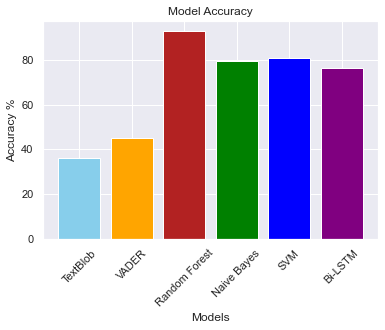

In [231]:
x=['TextBlob','VADER','Random Forest','Naive Bayes','SVM','Bi-LSTM']
y=[text_acc*100,vader_acc*100,rf_acc*100,nb_acc*100,svm_acc*100,lstm_acc*100]
#plt.bar(x,y)
plt.bar(x,y,color=['skyblue','orange','firebrick', 'green', 'blue', 'purple'])
plt.xlabel('Models')
plt.ylabel("Accuracy %")
plt.title('Model Accuracy')
plt.xticks(rotation=45)
plt.show()